In [1]:
import torch
import torch.optim as optim
import torch.nn as nn

from my_modules.model_learning.model_phases import train_epoch, valid_epoch, test_model
from my_modules.nsclc.nsclc_dataset import NSCLCDataset
from my_modules.model_learning import loader_maker

# NSCLC Dataset
`NSCLCDataset(self, root, mode, xl_file=None, label=None)`

`NSCLCDataset` is a custom dataset class of images from intensity- and lifetime- based MPM imaging from the `root` 
positional argument and associated labels as read from the `.xlsx` file at `xl_file` or found in the `root` if `xl_file`
is not input. Images have been externally preprocessed to provide traditional endpoints of imaging, namely:
* $ORR$ ($\frac{I_{FAD}}{I_{FAD}+I_{NAD(P)H}}$
* FLIM photon counts
* Phasor coordinates (real and imaginary components of Fourier Transform, $G$ & $S$)
* Bi-exponential Fit parameters:
  - $\alpha_1$
  - $\alpha_2$
  - $\tau_1$
  - $\tau_2$
If called, the bound fraction ($\alpha_2\% = \frac{\alpha_2}{\alpha_1+\alpha_2}$) 
and mean lifetime ($\tau_m = \alpha_1\%\tau_1 + \alpha_2\%\tau_2$) will be calculated internally.

Either at the time of the call using the keyword argument `label=YOUR_LABEL_CHOICE` or post-hoc by setting the attribute
`label`, an `NSCLCDataset` must have label set, otherwise it will raise an error when an item is retrieved. 
Available labels and their set-names (case-insensitive) are:
* Treatment response:  `'Response'` or `'R'`
* Metastatic assessment: `'Metastases'` or `'Mets'` or `'M'`
* Image masks: `'mask'`

When created, an `NSCLCDataset` will stack each desired endpoint (defined at the time of the call as positional argument
`modes`, or set as the attribute `modes`) into a 3D image stack of size $\left(C, H, W\right)$ where $C$ is the called
mode of the image, or the _channel_, ordered by the call order. Images are not held in memory, but loaded when 
`__getitem__` is called (usually indexing). By default, $ORR$, $G$, $S$, Photon counts, $\tau_m$, and $\alpha_2\%$ are
returned, in that order. This same stack can also be returned by calling `NSCLCDataset` with the mode argument of 
`['all']`. 

`NSCLCDataset` also provides further processing abilities including the following:
* `normalize_channels_to_max()` finds the max value for each channel of the stack and scales each channel to the max, 
such that no value will exceed 1. After calculation, the scaling values are stored as an attribute `scalars`. 
Normalization can be toggled quickly by setting the attribute `normalized` to `True` or `False` directly. This 
circumvents any need to recalculate `scalars` each time. 
* `dist_transform()` converts each channel of the image stack into a histogram. In order for the histogram to be 
meaningful across samples, normalization is automatically applied. This can be overwritten by resetting the `normalized`
attribute to `False` after calling `dist_transform`. The histograms are all normalized as PDFs, to 
prevent gradient explosions in training.
* `augment()` provides default data-augmentation behavior using `torchvision.transforms.FiveCrop()` set to crop the full
image into four corner and a center sub-image. Augmentation is applicable to both image and histogram datasets, as 
FiveCrop guarantees all images are distinct in distribution as well (in contrast to TenCrop).

Beyond processing, `NSCLCDataset` has a built-in method `show_random()` method that will randomly visualize 5 samples from
the set along with the labels. Attribute `name` which will automatically update to reflect all the specific dataset 
features (e.g. modes, augmentation). Attribute `shape` will return the shape of the data directly (without the label). 

In [2]:
data = NSCLCDataset('E:\\NSCLC Data - PMD', ['orr', 'photons', 'taumean', 'boundfraction'], label='Response')

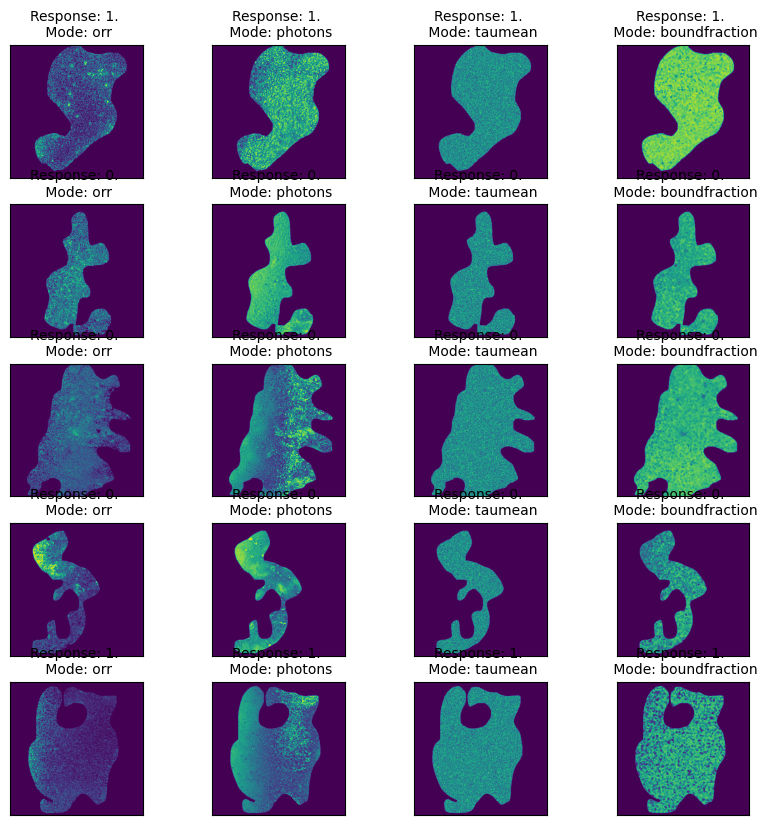

In [3]:
data.normalize_channels_to_max()
data.show_random()

In [4]:
# Set hyperparameters
# Prepare training/data-loading parameters
optim_fun = optim.Adam
criterion = nn.BCELoss()
bs = 32  # Batch size
kf = 5  # Number of folds for cross validation

# Iterable hyperparameters
hyperparameters = {'Raw': {'Fast': {'LR': 0.01, 'EP': 125},
                       'Mid': {'LR': 0.001, 'EP': 500},
                       'Slow': {'LR': 0.00001, 'EP': 2500}},
               'Augmented': {'Fast': {'LR': 0.01, 'EP': 125},
                             'Mid': {'LR': 0.001, 'EP': 500},
                             'Slow': {'LR': 0.00001, 'EP': 2500}}}

status = ['Response', 'Metastases']

results = {'Image': {'Single': {}, 'KFold': {}},
           'Hist': {'Single': {}, 'KFold': {}}}

In [5]:
# Create dataloaders using defaults
train_loader, eval_loader, test_loader = loader_maker(data)

[106, 20, 7]


In [ ]:
# Import, train, test model
from my_modules.custom_models.classifier_models import RegularizedParallelCNNet

# Set up training style manually
data_aug = 'Raw'
train_rate = 'Fast'
ep = hyperparameters[data_aug][train_rate]['EP']
lr = hyperparameters[data_aug][train_rate]['LR']
label = status[0]
model = RegularizedParallelCNNet(data.shape)
optimizer = optim_fun(model.parameters(), lr=lr)

# Save path for best-performer in validation
model_path = f'./{model.name}_Epochs-{ep}_{data.name}.pth'

# Train
train_loss = []
eval_loss = []
eval_accu = []
for epoch in range(ep):
    print(f'>>>{model.name} Epoch {epoch+1}/{ep}...')
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_loss.append(epoch_loss)
    
    vali_loss, vali_accu = valid_epoch(model, eval_loader, criterion)
    eval_loss.append(vali_loss)
    eval_accu.append(vali_accu)
    print(f'>>>Train Loss: {epoch_loss} >>> Eval Loss: {vali_loss}. Accu: {vali_accu}.')

    # Save best performing model
    if epoch == 0:
        best_acc = eval_accu[-1]
        torch.save(model.state_dict(), model_path)
    elif eval_accu[-1] > best_acc:
        torch.save(model.state_dict(), model_path)
        best_acc = eval_accu[-1]
    
# Test
model.load_state_dict(torch.load(model_path))
correct = test_model(model, test_loader)
accu = correct / len(test_loader.dataset)

print(f'|--Testing Accuracy: {accu}--|')

>>>Regularized Parallel CN Net Epoch 1/125...
